In [1]:
%matplotlib inline

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters

import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

# Collect the data for the google stock 

In [3]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2017, 1, 1)
x = web.DataReader("F", 'google', start, end)
x.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,13.87,14.00,13.75,13.97,38525811
2016-01-05,13.97,14.00,13.51,13.72,50267536
2016-01-06,13.56,13.56,13.05,13.11,61285453
2016-01-07,12.90,13.04,12.60,12.70,57846688
2016-01-08,13.05,13.10,12.50,12.54,46199413


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 5 columns):
Open      252 non-null float64
High      252 non-null float64
Low       252 non-null float64
Close     252 non-null float64
Volume    252 non-null int64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


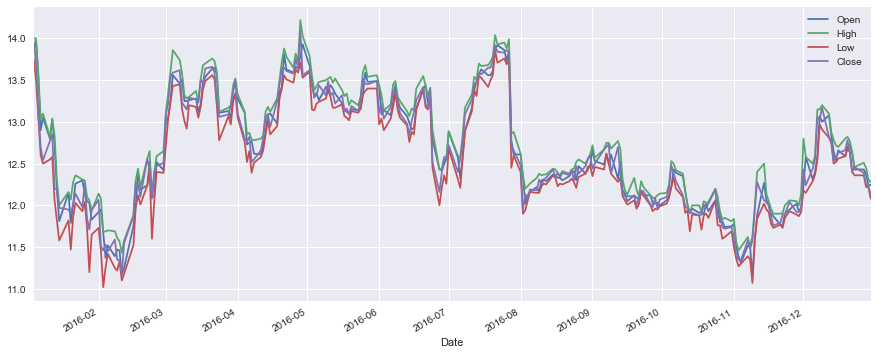

In [5]:
x.drop("Volume", axis=1).plot(figsize=(15, 6))
plt.show()

So, we loaded the google stock for one year. Now, we want to predict the High column.

# Create forecasting frame

In [6]:
df_shift5, y = make_forecasting_frame(x["High"], kind="price", max_timeshift=5, rolling_direction=1)
df_shift10, _ = make_forecasting_frame(x["High"], kind="price", max_timeshift=10, rolling_direction=1)
df_shift20, _ = make_forecasting_frame(x["High"], kind="price", max_timeshift=20, rolling_direction=1)

In [7]:
df_shift20.shape, df_shift10.shape, df_shift5.shape

((4830, 4), (2465, 4), (1245, 4))

In [8]:
df_shift5.head()

,time,value,id,kind
994,2016-01-04,14.0,2016-01-05,price
744,2016-01-04,14.0,2016-01-06,price
995,2016-01-05,14.0,2016-01-06,price
495,2016-01-04,14.0,2016-01-07,price
745,2016-01-05,14.0,2016-01-07,price


In [9]:
df_shift5["kind"] = df_shift5["kind"] + "_last_5_steps"
df_shift10["kind"] = df_shift10["kind"] + "_last_10_steps"
df_shift20["kind"] = df_shift20["kind"] + "_last_20_steps"

df_shift = pd.concat([df_shift5, df_shift10, df_shift20])

In [10]:
df_shift.head()

,time,value,id,kind
994,2016-01-04,14.0,2016-01-05,price_last_5_steps
744,2016-01-04,14.0,2016-01-06,price_last_5_steps
995,2016-01-05,14.0,2016-01-06,price_last_5_steps
495,2016-01-04,14.0,2016-01-07,price_last_5_steps
745,2016-01-05,14.0,2016-01-07,price_last_5_steps


`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [11]:
fc_settings = {
 'maximum': None,
 'mean': None,
 'median': None,
 'minimum': None,
 'standard_deviation': None,
 'sum_values': None,
 "agg_linear_trend": [{"attr": attr, "chunk_len": i, "f_agg": f}
                                 for attr in ["rvalue", "intercept", "slope", "stderr"]
                                 for i in [1, 3]
                                 for f in ["max", "min", "mean", "var"]],
"ar_coefficient": [{"coeff": coeff, "k": k} for coeff in range(5) for k in [10]]}
fc_settings

{'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 1, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 1, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 1, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 1, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 3, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 3, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 3, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 3, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 1, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 1, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 1, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 1, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 3, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 3, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 3, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 3, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 1, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 1,

In [12]:
X = extract_features(df_shift, 
                     column_id="id", column_sort="time", column_value="value", column_kind="kind", 
                     default_fc_parameters=fc_settings,
                     impute_function=impute,
                     show_warnings=False,)

Feature Extraction: 100%|██████████| 753/753 [00:04<00:00, 156.65it/s]
 'price_last_10_steps__ar_coefficient__k_10__coeff_1'
 'price_last_10_steps__ar_coefficient__k_10__coeff_2'
 'price_last_10_steps__ar_coefficient__k_10__coeff_3'
 'price_last_10_steps__ar_coefficient__k_10__coeff_4'
 'price_last_5_steps__ar_coefficient__k_10__coeff_0'
 'price_last_5_steps__ar_coefficient__k_10__coeff_1'
 'price_last_5_steps__ar_coefficient__k_10__coeff_2'
 'price_last_5_steps__ar_coefficient__k_10__coeff_3'
 'price_last_5_steps__ar_coefficient__k_10__coeff_4'] did not have any finite values. Filling with zeros.


In [13]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(251, 129)
(251, 103)


In [14]:
# Add last value as feature
X["price__y-1"] = y.shift(1)
X["price__y-2"] = y.shift(2)
X["price__y-3"] = y.shift(3)
X["price__y-4"] = y.shift(4)
X["price__y-5"] = y.shift(5)

In [15]:
# Drop first 5 lines
X = X.iloc[5:, ]
y = y.iloc[5: ]

In [16]:
X.head()

variable,"price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_1__attr_""intercept""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_1__attr_""rvalue""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_1__attr_""slope""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_1__attr_""stderr""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_3__attr_""intercept""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_3__attr_""rvalue""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_3__attr_""slope""","price_last_10_steps__agg_linear_trend__f_agg_""max""__chunk_len_3__attr_""stderr""","price_last_10_steps__agg_linear_trend__f_agg_""mean""__chunk_len_1__attr_""intercept""","price_last_10_steps__agg_linear_trend__f_agg_""mean""__chunk_len_1__attr_""rvalue""",...,price_last_5_steps__mean,price_last_5_steps__median,price_last_5_steps__minimum,price_last_5_steps__standard_deviation,price_last_5_steps__sum_values,price__y-1,price__y-2,price__y-3,price__y-4,price__y-5
id,,,,,,,,,,,,,,,,,,,,,
2016-01-12,14.071429,-0.956330,-0.260571,0.039820,14.000,-1.000000,-0.900,0.000000,14.071429,-0.956330,...,13.304,13.10,12.82,0.423207,66.52,12.82,13.10,13.04,13.56,14.00
2016-01-13,13.976429,-0.903021,-0.203571,0.043311,13.860,-0.892570,-0.480,0.242487,13.976429,-0.903021,...,13.112,13.04,12.82,0.243508,65.56,13.04,12.82,13.10,13.04,13.56
2016-01-14,13.928333,-0.901707,-0.179524,0.035141,13.860,-0.892570,-0.480,0.242487,13.928333,-0.901707,...,12.968,13.04,12.82,0.114961,64.84,12.84,13.04,12.82,13.10,13.04
2016-01-15,13.956667,-0.932283,-0.191667,0.028108,13.860,-0.892570,-0.480,0.242487,13.956667,-0.932283,...,12.822,12.84,12.31,0.278309,64.11,12.31,12.84,13.04,12.82,13.10
2016-01-19,13.990364,-0.950630,-0.204303,0.023580,13.944,-0.956569,-0.606,0.130583,13.990364,-0.950630,...,12.602,12.82,12.00,0.385663,63.01,12.00,12.31,12.84,13.04,12.82


#  Fit Adaboost

In [81]:
ada = AdaBoostRegressor(DecisionTreeRegressor(min_samples_leaf=7, criterion="mae"), n_estimators=20)
y_pred = [np.NaN] * len(y)

isp = 200   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[[i], :])[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 46/46 [00:44<00:00,  1.11s/it]


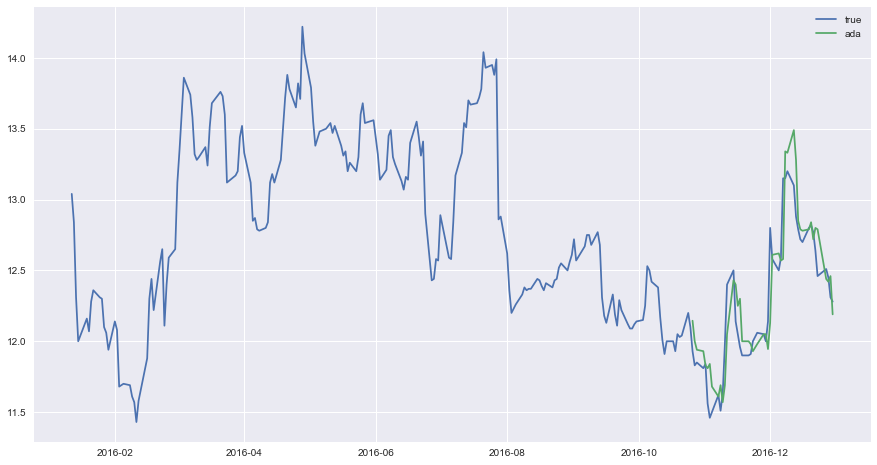

In [82]:
plt.figure(figsize=(15, 8))
plt.plot(y, label="true")
plt.plot(y_pred, label="ada")
plt.legend()
plt.show()

Now, we will also inspect last value before the prediction as a benchmark tool, denoted by y-1

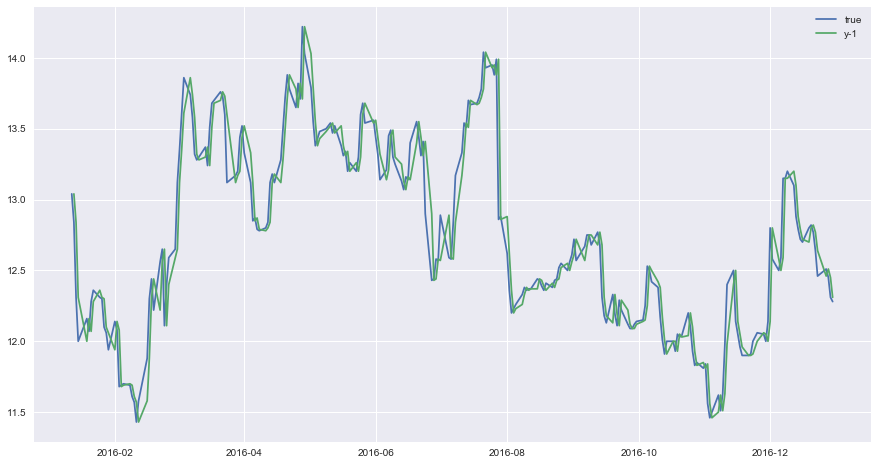

In [83]:
plt.figure(figsize=(15, 8))
plt.plot(y, label="true")
plt.plot(y.shift(1), label="y-1")
plt.legend()
plt.show()

Looks not too bad. The green curve is the output of the AdaBoost Regressor, the blue curve is the true High value.

We can also inspect the relevance of the extracted features

In [84]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

MAE y-1: 	0.127826086957
MAE ada: 	0.162608695652


However, we are not yet beating the y-1 benchmark, so we need to invest more time into building dedicated features or use a better model.

In [85]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False)

variable
price__y-1                                                                            0.628845
price_last_5_steps__median                                                            0.068086
price_last_10_steps__agg_linear_trend__f_agg_"max"__chunk_len_3__attr_"slope"         0.019322
price_last_5_steps__agg_linear_trend__f_agg_"min"__chunk_len_3__attr_"slope"          0.015182
price_last_20_steps__ar_coefficient__k_10__coeff_0                                    0.012950
price_last_20_steps__agg_linear_trend__f_agg_"var"__chunk_len_3__attr_"stderr"        0.012877
price_last_10_steps__agg_linear_trend__f_agg_"min"__chunk_len_3__attr_"stderr"        0.011039
price_last_20_steps__ar_coefficient__k_10__coeff_4                                    0.008093
price_last_20_steps__ar_coefficient__k_10__coeff_3                                    0.007348
price_last_20_steps__agg_linear_trend__f_agg_"max"__chunk_len_3__attr_"rvalue"        0.007113
price_last_10_steps__agg_linear_trend__f_

So, the minumum value "feature__maximum" during the last 10 values had the highest importance to predict the next value of the `High` column